# Perform a looping with the quadrotor

# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controller will be designed using an SQP solver.

Please submit your code as a runnable Jupyter Notebook.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [1]:
import quadrotor

print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)

Mass    = 0.5
Length  = 0.15
Inertia = 0.1
Dt      = 0.04
state size   = 6
control size = 2




## Part 1 - Setting up the trajectory Optimization (50 points)
1. Discretize the system dynamics using the Euler method seen in class - write the time discretization step as $\Delta t$ (use symbols not numbers for the mass, etc)
2. We would like the quadrotor to perfom a looping. Find and implement a suitable cost function to perform a looping and add constraint to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP (levarging your code from Homework 2) with a large horizon to check that you can do a looping.
3. Show plots of all the states and controls of the robot as a function of time. Describe your design choices (in a concise manner) in the report.

In [7]:
import numpy as np
from scipy.optimize import minimize

# system params
m = 0.500
I = 0.1
L = 0.15
dt = 0.04
g = 9.81
N = 250  

def dyn(z, u):
    # unpack state and control
    x, xdot, y, ydot, th, w = z
    u1, u2 = u
    
    # state derivatives
    dz = np.zeros(6)
    dz[0] = xdot
    dz[1] = -(u1 + u2)*np.sin(th)/m
    dz[2] = ydot
    dz[3] = (u1 + u2)*np.cos(th)/m - g
    dz[4] = w
    dz[5] = L*(u1 - u2)/I
    
    return z + dz*dt

def cost(x):
    # states and controls
    X = x[:-2*N].reshape(-1,6)
    U = x[-2*N:].reshape(-1,2)
    
    # circle path
    t = np.linspace(0, 2*np.pi, N)
    r = 1.0
    xd = r*np.sin(t)
    yd = r*(1-np.cos(t))
    
    # cost terms
    track = np.sum((X[:,0]-xd)**2 + (X[:,2]-yd)**2)
    ctrl = 0.01*np.sum(U**2)
    
    return track + ctrl

def cons(x):
    # control bounds
    U = x[-2*N:].reshape(-1,2)
    return np.concatenate([U.flatten(), 10-U.flatten()])

# setup optimization
x0 = np.zeros(6)  
x = np.zeros(8*N)  
x[:6*N] = np.tile(x0, N)
x[6*N:] = 5  

# bounds and constraints
bounds = [(None,None)]*6*N + [(0,10)]*2*N
cons_dict = {'type':'ineq', 'fun':cons}

# solve
res = minimize(cost, x, 
              method='SLSQP',
              bounds=bounds,
              constraints=cons_dict,
              options={'maxiter':500})

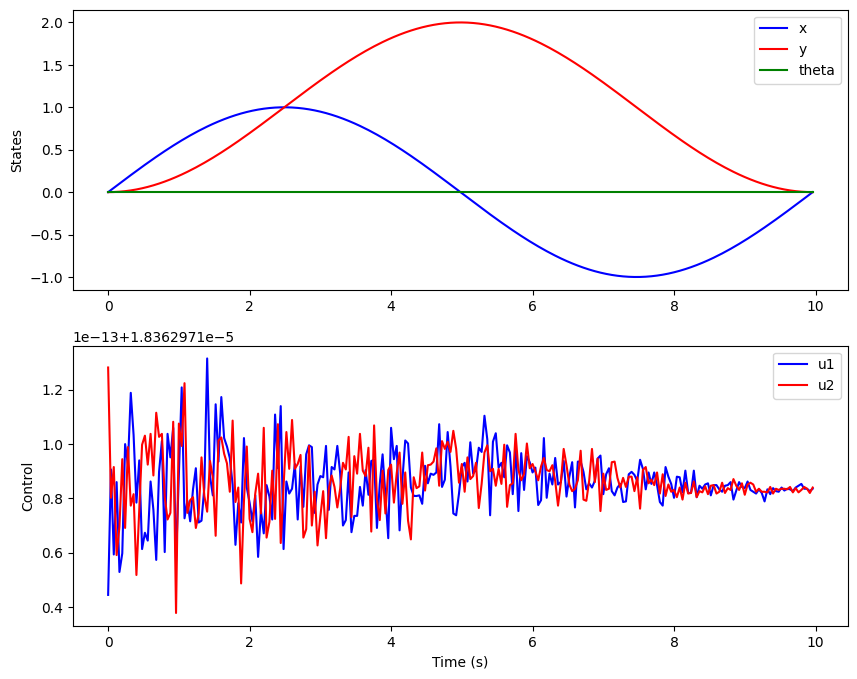

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAccJtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
ESpliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3umtv+o/J6/ws88Qe3ONgY
E3SiGzrp56Amktu93aN6yZPklWeco+tiMnO/bnIj0hwZ65zjD1Usn39ub7ryrrIiSvziYtq9xvi0
R3TvRrRv1mxOOREDXkf5gu4VQJC8cMha17qTiTN8HhirVVd7fJx49q7tGP20dpE3VYns3/Vn3Qaf
fk8Qk40K877a4gJCKGibR0F+clKUU8YWj4r7jtHkBqvdT8HuUUf+2M/Tg9cFZ4KtipsUT9R8e1Ve
UJLnUdluVoTXMhVzsqlXylAN9gVw6gXCXLV/USTybfR/wxSWB9Icl+r0E9UENF6FMLfei953KJPa
SzdQJtPBf2etfyyM6GOIg7ws1/8vyRy07kftrhBzKH45LUx5j9zi9JJ/n0bLaNyZPxp9FHmYFgD0
RMgD2bDGHzsiEDrudc6dut9Iq2nH2Bokle4mEa3OfP3rMu5gO+Jfadwpg5ARtfKz5qD/VNAe0J2w
CVpe0Zp2szQnNz1WCvze+i5AD1wwISoiChDAh3q/tC6M2K/ljpkSftlRrgvznkeVMponBbMeat8S
qoMcslegFuqp+eZpzblwnu/862IwS/A5oX2tlxhMkmGSF6m2t9EO0rQF+0ZFjNPLn9+pgtfLhA4C
PFt/8EVcZey7SxIajlqv496xPZWVh7439qV6l/VNZ19lhjqJR94ofVOn6iENgPG/7MhbTe2cQ7fI
agyeRotSUpYr5c6aNxRFD0eqv8/C//MK4qlNKUddhnGntW4XsqzbiBv3A6pB54VmAZqy/liTecRp
51HWAFm2Iqn26646Frhy2l0erBq5FzYvnhDTC98452MWMIWvKXMdO9vg3DwQQ34NrBfE0MxUoCtw
vlq7G/DXUf64l/lEVEWbaNZLsCS4/7d3ObVRUs74cZUZAAD4o9MAbb5ZjISxjNBbtlFmFNV5vmrD
HPcSTcVmiNYoj5768YeTwDkeWExJhAXUf9If3awAEDBIe1lAAAADAFBGro9zhsDE6nWJAVw2udsr
McJQ+ZVEvZdVF3U+pOS54/5f6VSca0qCDawT7tRWi+ylV8krxB08hJL577fojMU7axihz6kzx6/B
Lo4fAPFf4q25q77vcVKGh4br48p+LkLx+zJuSp2hc6IUQVGNlPQlcSaWfPJgyE87XnS+JW1qXOaQ
WCobS78eJfa/Vkev+nFMYGAzkLlY5lbUYp1GakOd2nf1GDYe3znBmpzWGHKgMu4KYqrfr3WjW6RC
85M/IJKohFtKHJFHAxGACIB5/9mMOZ+u359VHOTSMVdvHZkRseJEjfDqNOiyQrY3/WjvXsyuZwJb
wYQj7oCbCT4f5p6huAIBbla2O+o5jcRHS68zfa2Wwul2kzroRRifznhha5TUA5gvFcY6LIor6JZ4
wE2PtU8e/+o/Jmsv/I3rImzRytTYCwHfOj79IstKMXTA7wze8tkBBj0TrhM+tzBNNih8AAADAAAD
AAAIp9+4V2lC1kgAGSnv34cOl4XFugNj9vLqzhb399N2IHyM+iVhPE6CVbuOEnkCerB/vnH24TFw
c67R6qUprwQkWHunPBu3dVDoVLrbuO84748Bm1czJ0bHG/FgMwWLD4PtVFa7dKuurRAmC+JmKty2
oWkV3SFCq26ZNOOyh3J9YbEzhli0uNZjTY74qOxtFulB5nEzEJ2N6yZEHJGZzXoQfiJD69a5wd4P
7owWBRAZz86quwZxuh4RWWbQNRYpcQTNipWBRsAZORlNGSKqhBaaiqN3rA6jkKrpSvXnpnqCAOT/
r5o0lbnPreq8SDZzeZUdBTNGE6qO2ye2PkFtP1h7a8ntBw2cnxnll1/rdtY+wzkL1Lge4FfHPb01
FsbL0M6y7OgtNB7ZzGZoxoh4m1VY77Adk1MKeddzpD6Oa++Zt2rbSZrEusz3HR8oTnTPqGAUOK8L
zicJjAjzt2hjYuqK9bhRVNdT3uN39Cg1Wrt4DCnMiTM5RDpjmwW04T7cikgF0xIIIpjxy7O6O7rW
158AiEA8ad2pPgY2jiBh8hyzmz06hElZ5vacZQnK+ITmPlMOWSI5YjjKo5R+D/5NjVvx92B9dxyb
8xIltb691pjmFqppspnrMVaYOgM1BI8du/rZkSl95lhTqD5+WIWxRLY7v1NZugKy3+wQlnyoFlAO
8FcA5svYdV+92McnNgiwAAADAADdobPUf+lfzmNwpXrS2DRjer7jHCzBLd7CNpeSK/q7dRhzHFmf
BMI1uBM1nzJ1hepr9c8PZvkyFj2buCS8/f6MDSc7WXxy7/PVsyLeBMf+xyfZPgICIPjJcGrXn0j8
VpeCjswUVyBRTKtPrjz9uN/XdLWvTT10PZGd1aeyg3/xYzM5gj9HAmhAwht3QwgPjxEV4v4DszHz
wp7Hd4QQ8/3Z83kE0tKHqwU+/s78matu56VmyDafeW1gc1YcurtXAp/XAQ3z0Z1yKTM9IuSUuDmw
Q0cgRSPS4oyBtnucZWIzc

In [13]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# get trajectory data
X = res.x[:6*N].reshape(-1,6).T  
U = res.x[-2*N:].reshape(-1,2).T  
t = dt * np.arange(N)

# setup plots
plt.figure(figsize=(10,8))

# state plot
plt.subplot(211)
plt.plot(t, X[0], 'b-', label='x') 
plt.plot(t, X[2], 'r-', label='y')
plt.plot(t, X[4], 'g-', label='theta')  
plt.ylabel('States')
plt.legend()

# control plot  
plt.subplot(212)
plt.plot(t, U[0], 'b-', label='u1')
plt.plot(t, U[1], 'r-', label='u2')
plt.xlabel('Time (s)')
plt.ylabel('Control')
plt.legend()

plt.show()

# animate trajectory
quadrotor.animate_robot(X, U)

## Part 2 - Model predictive control (MPC) (50 points)
1. Use the trajectory optimization method from Part I to design a MPC controller and test it using the simulator below. In particular, verify that it can handle perturbations by calling the ```quadrotor.simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state anc control evolution.
2. Explain your intended design in the report, including the cost function and found control law

The ```quadrotor.simulate``` function takes as an input an initial state, a controller, the number of discrete time steps and a boolean value to indicate the presence of perturbation. The controller has to be a function taking as an input a state and time index and outputting a control vector.

To visualize the trajectory, use the ```quadrotor.animate_robot``` function
and show the animation (show the plots in your report).

In [14]:
N = 50

def dyn(z, u):
    # state and control
    x, xdot, y, ydot, th, w = z
    u1, u2 = u
    
    # derivatives
    dz = np.zeros(6)
    dz[0] = xdot
    dz[1] = -(u1 + u2)*np.sin(th)/m
    dz[2] = ydot
    dz[3] = (u1 + u2)*np.cos(th)/m - g
    dz[4] = w
    dz[5] = L*(u1 - u2)/I
    
    return z + dz*dt

def cost(x, z0):
    # states and controls
    X = x[:-2*N].reshape(-1,6)
    U = x[-2*N:].reshape(-1,2)
    
    # circle trajectory
    t = np.linspace(0, 2*np.pi, N)
    r = 1.0
    xd = r*np.sin(t)
    yd = r*(1-np.cos(t))
    
    # costs
    track = np.sum((X[:,0]-xd)**2 + (X[:,2]-yd)**2)  
    ctrl = 0.01*np.sum(U**2)  
    
    return track + ctrl

def constraints(x, z0):
    # states and controls
    X = x[:-2*N].reshape(-1,6)
    U = x[-2*N:].reshape(-1,2)
    
    # constraints
    cons = []
    
    # initial state
    cons.append(X[0] - z0)
    
    # dynamics constraints
    for i in range(N-1):
        z_next = dyn(X[i], U[i])
        cons.append(X[i+1] - z_next)
        
    return np.concatenate(cons)

def mpc(z, t):
    # initial guess
    x = np.zeros(8*N)  
    
    # bounds
    bounds = [(None,None)]*6*N  
    bounds += [(0,10)]*2*N      
    
    # solve optimization
    res = minimize(
        cost, x,
        args=(z,),
        method='SLSQP',
        bounds=bounds,
        constraints={'type':'eq', 'fun':lambda x: constraints(x,z)},
        options={'maxiter':100}
    )
    
    # first control input
    U = res.x[6*N:].reshape(-1,2)
    return U[0]

# simulate
z0 = np.zeros(6)  
T = int(10/dt)    

t, z, u = quadrotor.simulate(
    z0=z0,
    controller=mpc, 
    horizon_length=T,
    disturbance=True
)

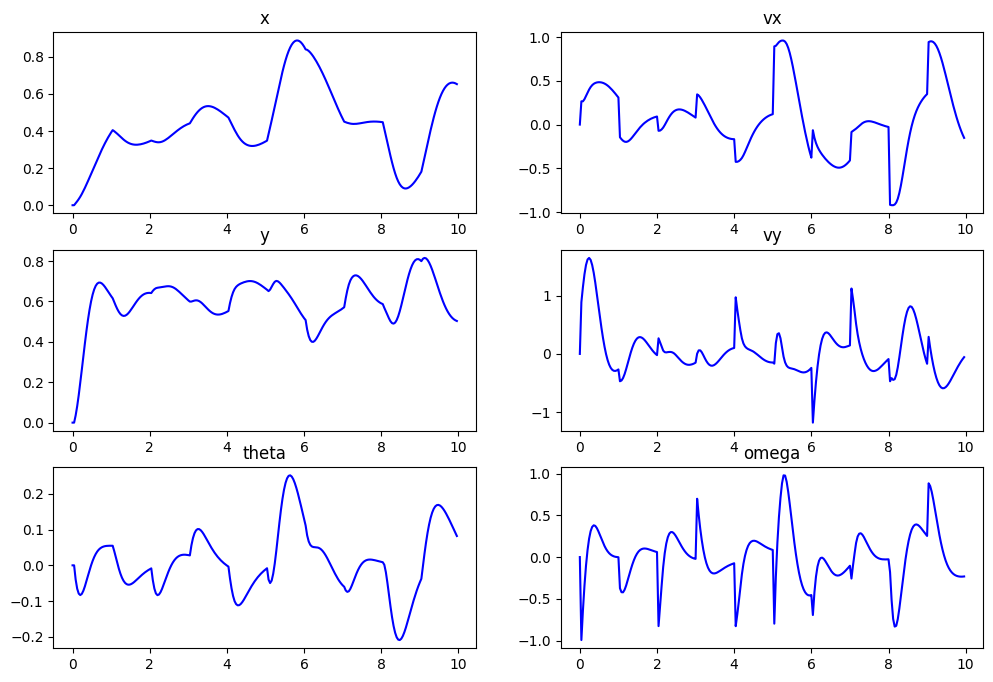

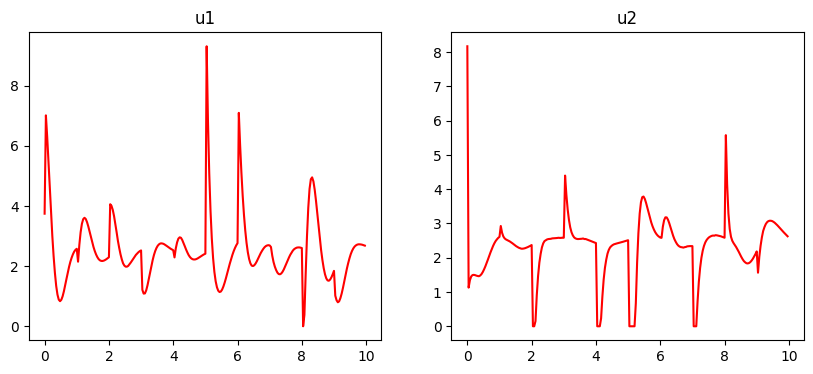

Simulated trajectory:


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAlbxtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EX5liIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3umtv/f+/dadc88O/CgNgS
WqofAorM+LAmktu93aN6yZPklWeco+tiMnO/bnIj0hwZ65zjD1Usn39ub7ryrrIiSvziYtq9xvi0
R3TvRrRv1mxOOREDXkf5gu4VQJC8cMha17qTiTN8HhirVVd7fJx49q7tGP20dpE3VYns3/Vn3Qaf
fk8Qk40K877a4gJCKGibR0F+clKUU8YWj4r7jtHkBqvdT8HuUUf+2M/Tg9cFZ4KtipsUT9R8e1Ve
UJLnUdluVoTXMhVzsqlXylAN9gVw6gXCXLV/USTybfR/wxSWB9Icl+r0E9UENF6FMLfei953KJPa
SzdQJtPBf2etfyyM6GOIg7ws1/8vyRy07kftrhBzKH45LUx5j9zi9JJ/n0bLaNyZPxp9FHmYFgD0
RMgD2bDGHzsiEDrudc6dut9Iq2nH2Bokle4mEa3OfP3rMu5gO+Jfadwpg5ARtfKz5qD/VNAe0J2w
CVpe0Zp2szQD/j1WCvze+i5AD1wwIHk0RBDAh3q/tC6M2K/ljpkSftlRrgvzn9eVMponBbMeat8S
qoMcslegFuqp+eZpzblwnu/862IwS/A5oX2tlxhMkmGSF6m2t9EO0rQF+0ZFjNPLn9+pgtfLhA4C
PFt/8EVcZey7SxIajlqv496xPZWVh7439qV6l/VNZ19lhjqJR+IIfVOn6iENgPG/7MhbTe2cQ7fI
agyeRotSUpYr5c6aNxRFD0eqv8/C//MK4qlNKUddhnGntW4XsqzbiBv3A6pB54VmAZqy/liTecRp
51HWAFm2Iqn26646Frhy2l0erBq5FzYvnhDTC98452MWMIWvKXMdO9vg3DwQQ34NrBfE0MxUoCtw
vlq7G/DXUf64l/lEVEWbaNZLsCcaKB6XObVRUs74cZUZAAD4o9MAbb5ZjISxjNBbtlFmFNV5vmrD
HPcSgnCcMSxUS1p12uphAGCmpjyRkqPE/6Q/u1gAIGCQ9rKAAAADAKCNXR7nDYGJ1OsSArhtc7ZW
Y4Sh8yqJey6qLup9Sclzx/y/0qk41pUEG1gn3aitF9lKr5JXiDp5CSXz32/RGYp21jFDn1Jnj1+C
XRw+AeK/xVtzV33e4qUNDw3X0MpRoOKD9mTclTtC50QogqMbKehK4k099OTBkJ52vOl8StrUuc0g
sFQ2l348S+1+rI9f9OKYwMBnIXKxzK2oxTqM1Ic7tO/qMGw9vnODMEa268BYQT9vzbOpbpXcPwky
wc/JAOanHZCWJHSVEhZeAp/efa7MXraIq+dcowV2OS1HE3mVJy2UHfBXe9hz4+jjvCdf6wrTqe+k
DtvVv9C/dATIPPhamN6G4BAKzG5PvC210gOlv5m+2C/XJduz3eJCiA4h9AFhVNQDmC8VxjosijrJ
MSDQmx9qnpN/2cGpfl66uwZEU2PzkdI1Z/FY+/T/Krp+cFYm2Of+2y7egctODp74mED2EG8AAAMA
AEroAACnqwAkchLv9jBOmSKj9ESL7BWsZtBPPDCHOtjWNL3H+MHNEVJ5L0o19az8mS8pi/p5iB4/
WH5yj2XRq0UtYtfnAWxMJqZj0pRzpD/3F6PfB9KOAGz21SNApntw839b4KcLIE6+BJkzwp3PDY3N
ZCZpqr/zhbOKwpIel7lPIqC9GyzGaoWLyadiOcJ3hj6mX0IhvXJ4OEEjBK0zxbwPhIDg7cT9MwyT
Ne6jH2hMZdnTsR0LahaRXdIXu15Yr9DgJNjsRyxr86yLTMVKcAp80TyezatFtvlUvpvfCeMPsDkj
M4K+EqmwfVNDGGD0/YheC1dJmUM0yd72GPHZ6NO7WYIc2a/zfqkELhVRgKuFQ7eRiyZEat2YyTPp
aKNkBhAp274hski+nrm7fxgsdIfR2Q5cje7WvVcIkEfy/hvQG6ZGPpN4itVX8wks04p/psHPQJ0V
LHlgtjMcA5Wne3lXDbct4f2uZKuJy20qQR0d1Qf3I9tYxw8wjd3Z5KVmHL5a/sOxfJDvESDcFsR8
wWi7TByW75nE9344zJXoOJe+pwJ3v43IkiKzj3v3i5gYQENL6JrwTK4/NpKiqgDwyPhxK7SNAioP
D6gkoPcKq+V2iD8hoGDUua5ZUOtl67oS3Ienc4ZNytzEKJs3ZhKTyZjM7ANOPJN6gnVqc1dYxdW9
Uh9SXoSbn9kfXwK9f5YeUfzYV+9zalaBxSYiKneHvpF/oodpqwlCuc1VHtDCmvC/7m+PPMy9RQtm
YJw9RbzqNfnO2Fr32vTsWXVBhQ32OI/uXjD261u1YEjawnbWDRbAIajGWiXsSAAAAwAHc2388VC6
b4T5cx/TEOOaN/sy/JioPbmDTPmCN0cN2JqCNDoVpm7jphSMgsGr3aQKOcLM79ghqRdZ9An8BofD
9JhZ4XtLwo9ehSJo3NCKhuCsYNbwEBEHxlDrHCXFv2IWzInwSTjeLezAtLHCu3ASHEzcgRH+fpMi
vUJZlcP9nWf80FkXJpfPt

In [15]:
# plot states
plt.figure(figsize=(12,8))
labels = ['x', 'vx', 'y', 'vy', 'theta', 'omega']

for i in range(6):
    plt.subplot(3,2,i+1)
    plt.plot(t[:-1], z[i,:-1], 'b-')
    plt.title(labels[i])
plt.show()

# plot controls
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(t[:-1], u[0,:], 'r')
plt.title('u1')

plt.subplot(122) 
plt.plot(t[:-1], u[1,:], 'r')
plt.title('u2')
plt.show()

# animation
print('Simulated trajectory:')
quadrotor.animate_robot(z, u)

## Bonus (10 points)
Add a state constraint to perform the looping while maintening a positive altitude. Use the origin as an initial state.

In [17]:
def dyn(z, u):
    x, xdot, y, ydot, th, w = z
    u1, u2 = u
    
    dz = np.zeros(6)
    dz[0] = xdot
    dz[1] = -(u1 + u2)*np.sin(th)/m
    dz[2] = ydot
    dz[3] = (u1 + u2)*np.cos(th)/m - g
    dz[4] = w
    dz[5] = L*(u1 - u2)/I
    
    return z + dz*dt

def cost(x, z0):
    X = x[:-2*N].reshape(-1,6)
    U = x[-2*N:].reshape(-1,2)
    
    t = np.linspace(0, 2*np.pi, N)
    r = 1.0
    xd = r*np.sin(t)
    yd = r*(1-np.cos(t))
    
    track = np.sum((X[:,0]-xd)**2 + (X[:,2]-yd)**2)
    ctrl = 0.01*np.sum(U**2)
    
    return track + ctrl

def constraints(x, z0):
    X = x[:-2*N].reshape(-1,6)
    U = x[-2*N:].reshape(-1,2)
    
    cons = []
    
    # initial state
    cons.append(X[0] - z0)
    
    # dynamics
    for i in range(N-1):
        z_next = dyn(X[i], U[i])
        cons.append(X[i+1] - z_next)
    
    # altitude constraint (y > 0)
    altitude = -X[:,2]  # negative because inequality constraint needs to be <= 0
    
    return np.concatenate([np.concatenate(cons), altitude])

def mpc(z, t):
    x = np.zeros(8*N)
    
    # bounds
    bounds = [(None,None)]*6*N
    bounds += [(0,10)]*2*N
    
    # constraints with altitude
    cons = {
        'type': 'ineq',
        'fun': lambda x: -constraints(x,z)
    }
    
    res = minimize(
        cost, x,
        args=(z,),
        method='SLSQP',
        bounds=bounds,
        constraints=cons,
        options={'maxiter':100}
    )
    
    U = res.x[6*N:].reshape(-1,2)
    return U[0]

# simulate
z0 = np.zeros(6)
T = int(10/dt)

t, z, u = quadrotor.simulate(
    z0=z0,
    controller=mpc,
    horizon_length=T,
    disturbance=True
)

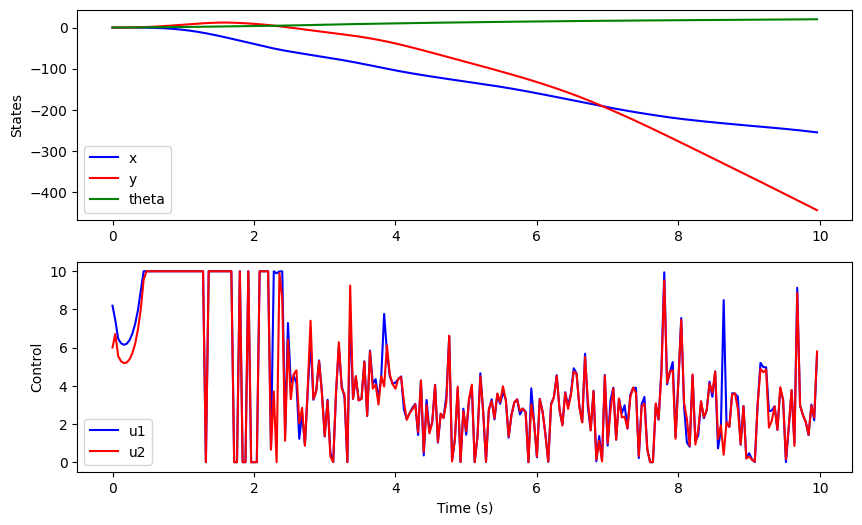

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAVattZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EdVliIQAN//+9vD+BTY7mNCXEc3onTMfvxW4ujQ3vc4AAAMAAAMAAAMAADSY0H4zd2rDhiAAAAMA
JgAGCANgAzAEdwBJhifrPwALwRFkBJwPzJUmFGT2qHXo4m6RCitIlhRYet3pioe7PtHMnO4JkntJ
ujXVK9mpvpov1Dq5CrLp26+E/qiy2XJ1DXbFQFIeD6dj4d/Ycg4MlRjSj5F/jO4dneZbKchBkxER
1+dwaLseoQTUOIHe+AjMd/01j3lkHunyumHGATGipvB8Jo3/1xG5EMuFbAUu0w2IiCDF5+ip5thN
vRDtVkCV+DUpkegcyhaqQzEw7nFKV36A9KUOXUuOlw8+DjYb/GGAXOWUXawhENdBy6VKY9qGyIuN
5SznASh5OwZD+rlx52dt16SaXlDqigzd++8vmdkFWJ5TEQldZ1JZBAWotT0vcbD5AzJUrq2q+u+I
eYPnS4SXNsIgA8tMwi35JL8AAAMAAAMAAAMAAEVCE862NuBasFhdFthCHcWW3ByorYjbjZQwRMID
5ZWw7d6cIwG6T1YURWNN8cQs1rx87JrAHHDxh6u9KYY/C9Z3xGdR9RaLN1Pmb/qz7oJSRytAScaF
xTFsPojpkJqsPnvLaUWvinjC0e5vP6bQMsjAdbw9yhO/sMtNdhZ62Wh/kuEh+ftW3iRyNJ8AqXCz
q1QckPvwotEx5SqAexq4dQLhLZkG01lcL+HiYuyiB3/zr9svI5wTZlVABKm6c45mJ61zGeP2KJA9
pnYkmh2wgfJaBwwfxDeVUtkYnsq+ngYthwVktPy7noN0d48oTRiRu4a4IsR6cO++l/qPCYTy6ezU
kWbCO11mmyNAxqt+xsxviYMCXbB9qR+s9C3DSY5+71elpH/L9n+QT3QiCVG2im4ZQ5dlvwptny2g
oDIC8B3LUtjQkElBD9fp2E2tEj3drdKM4c6+QCND2TQusqNcF+ilH8IxqcDE1iVOiF/1bi/W9ko3
FKCTzXd9pOquYOUqRF+lfHNC+1suMJkopOlNLUgzeDM/EW2oBcwGaeXP79TBa+XCBwEeoMPeUNeS
9l2liN5h+99rTvxPZWVh+Cr+3/TA9Ut3sGPk2ZzbBbE2gAzpitrfBbpoWthjGlrRUR0S/YjZb0DK
f1te8ZJVKc0OaV6imj/P5Cfzit5xKR4IKS7V+uwr+r8WvZVSlQEf1Cma3NMb5USTTNQTb2GqXmcd
nxim1bHkmTdTzkFvXc8qWdgrJ7g/mkkWiR0SDifsog77hR15NETnZDT8cZcvJOwqMuJxCQoZjKc1
ZjN9Y/qEVVJ4Dv9fp/M/yzb9VocjTV2R2z8JgqnYADkwd2mjDAL9TvBUTd3XA1quhkjmYzU8n9uM
Mm1bMwCCIrdRH6vwHfzejF0wTUJOG5ViH7ef00kfPySjfXXuVlMickTDxqvon/eeb6ARtj28WzSc
L2bFLBgJ+kTdyzytVSk9xs0GNYRSJ5I6GmnVN6THlza2I7Ly3uftK2in7xv4oNhvN6uEIq+hNRDv
z6zHeK3FRX94WQC2EqwVD4DOXSVghgd3OiFEFR+8LmJFPPM64UbJdDtnrDm6lzmkMA6nqoAseOMR
aXN+mVSE9TyWKhKdRQvc4BOhODiJex2edrWma79LKiz1jQw8fJHsw3MfqXjZQKJJp/eWZBdsh97k
yEUk9qgNFiDZPNmeOq3svqru+5ix/WcyfcFJ3KhsgFINX6abn1FWuUhk5a5TBAVHAv60IAkMi4pC
wOTy/1nI0r2xCINckdE4YrxDs7908aKuQBXKLRxzVBb4AAnSVqTdLRfAuz6x/mB3EL1ONAc+wCBB
Sa4B7Ug0h91AVeyeC4QnY2JiTAtcJe4JSkNA3GxtVeSKE0wY8dIaeBOwBL8utMWMSbVzhdkyCT31
IyBXa54TO9z6hEYirouggdKO/h3GwyCLKR06zc884Z077I/nhgqE7rqHlokKQoC/0dLRThhh8XTf
W3EKmQ/DT8nOn4Z0Pc4vcmHM10TZpoUnLrDuJWUAARxq9hPNqKL11FqeUFUios/huZK2x1KTOjl6
VYkbu1h/KmUJjGIhuXp9GBsNIFx1G/x/4fpJqUk64cgzAQLgpEIEonydYBmzMMsKFlveycdjp/gQ
tLa2TjEIE51R4RgHzczlE4P9S3mrOp5aUNgSJFbYZ7ofUbglvSYi68SWNXClNm3mqehEN65PBwkD
6od5ui3a4lWeNLbx75+BiF8KzQNr6RfldL0LahaRXdIXjCGG5L+KL8nfCppnnDLFpmHa4279+MYi
TRIaS7OAmLdXhPGH2ByRmUA8f69eZ2WlfKmgIA6gW6Qx60jScD7LXXMITQktsmaCa7Sn8I/Su0pU
RnBMfD3aImI1expmaWxCVFWqgoFHHCLFKENVE1Slp5LZm+Tint0uG8burBuFDSIep/+Dpi12O0Rb
qDt3l2T5wgfXvuIwDLtSyRVaInNFKX4dQ/e4QfABsz3t8nHjKWoKS0HSfa0dcp4H5/jJeRuNXgBM
V2HSdEiNvPRAf1U/Tzc7JxCasRrf+3Ge3/rbTW5cG2CBfDEKZg8cOYUomZTgwDUkcBCzAZ5kCvZG
UE14JoLEGCRDhnvL02lB6bI5Uuk/O3aDskzLdbWcK8XWKL3GBNJjcsqKSeeTudcD8JXXB6MOxq1D
10OrsZ6IXg7tc2M4zySsfcPzzXRqFH6+0002VuMAYp/GRjY5/xVqdToU6saBvShczTVtRo39B4ec
yyLyA45tgW0MR1p8GpmPLq2ABipAnIkXeHKRarzpE/B7tkXu5MyO/D9aTMcWGaDU3LzFUVoJqCQ5
7FWAAAADAAG8LC3bbzOHKyfpOQ3fbDi8rmU4A/yhwQkCt6YcsF4vlRIhfXKVMvKD4kE6SsqTrC9T
X6536A5SlHzeHj24zkGPS

In [18]:
# plot results
plt.figure(figsize=(10,6))

# states
plt.subplot(211)
plt.plot(t[:-1], z[0,:-1], 'b-', label='x')
plt.plot(t[:-1], z[2,:-1], 'r-', label='y')
plt.plot(t[:-1], z[4,:-1], 'g-', label='theta')
plt.legend()
plt.ylabel('States')

# controls
plt.subplot(212)
plt.plot(t[:-1], u[0,:], 'b-', label='u1')
plt.plot(t[:-1], u[1,:], 'r-', label='u2')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Control')

plt.show()

# animate
quadrotor.animate_robot(z, u)